In [ ]:
! nvidia-smi

Tue Aug 23 02:25:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import h5py
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import cross_validate, KFold

In [ ]:
test_size    = 0.20
h5_color     = '/content/drive/MyDrive/Mineria/DatosFinales/Dataset_Transformado/Datos_aumentados/color_features.h5'
h5_colorLb   = '/content/drive/MyDrive/Mineria/DatosFinales/Dataset_Transformado/Datos_aumentados/color_features_labels.h5'
h5_texture   = '/content/drive/MyDrive/Mineria/DatosFinales/Dataset_Transformado/Datos_aumentados/textural_features.h5'
h5_textureLb = '/content/drive/MyDrive/Mineria/DatosFinales/Dataset_Transformado/Datos_aumentados/textural_features_labels.h5'
scoring      = {'accuracy' : make_scorer(accuracy_score),
                'f1_score' : make_scorer(f1_score, average = 'weighted'), 
                'precision' : make_scorer(precision_score, average = 'weighted'),
                'recall' : make_scorer(recall_score, average = 'weighted')}

In [ ]:
#cargar los datos
h5f_color   = h5py.File(h5_color, 'r')
h5f_colorLb = h5py.File(h5_colorLb, 'r')

color_features_string          = h5f_color['Pest_Color_Features']
color_features_labels_string   = h5f_colorLb['Pest_Color_Features_Labels']

color_features = np.array(color_features_string)
color_features_labels  = np.array(color_features_labels_string)

h5f_color.close()
h5f_colorLb.close()

print("features shape: {}".format(color_features.shape))
print("labels shape: {}".format(color_features_labels.shape))

features shape: (10695, 512)
labels shape: (10695,)


In [ ]:
h5f_texture  = h5py.File(h5_texture, 'r')
h5f_textureLb = h5py.File(h5_textureLb, 'r')

textural_features_string          = h5f_texture['Pest_Textural_Features']
textural_features_labels_string   = h5f_textureLb['Pest_Textural_Features_Labels']

textural_features = np.array(textural_features_string )
textural_features_labels  = np.array(textural_features_labels_string)

h5f_texture.close()
h5f_textureLb.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(textural_features.shape))
print("[STATUS] labels shape: {}".format(textural_features_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (10695, 13)
[STATUS] labels shape: (10695,)
[STATUS] training started...


In [ ]:
global_features = np.hstack([color_features, textural_features])
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(textural_features_labels.shape))

[STATUS] features shape: (10695, 525)
[STATUS] labels shape: (10695,)


In [ ]:
"""
    Se implementa la separación de las correspondientes caracteristicas considerando su importancia
"""
X = global_features
y = color_features_labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    y,
                                                    test_size   = test_size,
                                                    random_state = 15)

X_train.shape, X_test.shape

((8556, 525), (2139, 525))

In [ ]:
"""
    Declaración del kernel a implementar
"""
sigmoid_param_grid = {
        "kernel": ["sigmoid"],
        "gamma": ["auto", "scale"],
        "C": [0.0001, 0.001, 0.1, 1, 10, 100, 1000],
        "decision_function_shape": ['ovo', 'ovr']
}

In [ ]:
"""
    En base al kernel declarado se corresponde implementar SVM con el tipo de kernel
    sigmoid.
    Para posterior empezar su entrenamiento correspondiente
"""
svm_sigmoid = GridSearchCV(svm.SVC(), sigmoid_param_grid)
history = svm_sigmoid.fit(X_train,y_train)

In [ ]:
"""
    En base al modelo entrenado se corresponde en obtener las metricas correspondientes del modelo
"""
y_pred = svm_sigmoid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print('Accuracy (Sigmoid Kernel): ', "%.2f" % (accuracy*100))
print('F1 (Sigmoid Kernel): ', "%.2f" % (f1*100))
print('Precision (Sigmoid Kernel): ', "%.2f" % (precision*100))
print('Recall (Sigmoid Kernel): ', "%.2f" % (recall*100))

Accuracy (Sigmoid Kernel):  92.10
F1 (Sigmoid Kernel):  92.08
Precision (Sigmoid Kernel):  92.06
Recall (Sigmoid Kernel):  92.10


# Cross Validation

In [ ]:
"""
    Se implementa cross validate para verificar la funcionalidad y efectividad del modelo correspondiente.
"""
results = cross_validate(estimator=svm_sigmoid, X=X_train, y=y_train, cv=8, scoring=scoring)

print('Accuracy (Sigmoid Kernel): ', "%.2f" % (np.mean(results['test_accuracy'])*100))
print('F1 (Sigmoid Kernel): ', "%.2f" % (np.mean(results['test_f1_score'])*100))
print('Precision (Sigmoid Kernel): ', "%.2f" % (np.mean(results['test_precision'])*100))
print('Recall (Sigmoid Kernel): ', "%.2f" % (np.mean(results['test_recall'])*100))

Accuracy (Sigmoid Kernel):  91.57
F1 (Sigmoid Kernel):  91.61
Precision (Sigmoid Kernel):  91.71
Recall (Sigmoid Kernel):  91.57


# Matriz de confusión

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

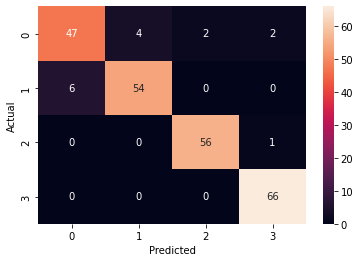

In [ ]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()